# NetMET training and avalidation

## Imports and parameters

In [11]:
from analysis_tools import Dataset, Process
import utils.tools as tools

In [12]:
# constants
l1_met_threshold = 80
puppi_met_cut = 0

## Function definitions

In [3]:
def get_data(dataset, output_y=True, output_df=False, nfiles=-1):
    # features to consider
    feature_params = {
        "inputs": ["Jet"],  # hwPt, hwEta, hwPhi
        "inputSums": ["methf", "mhthf", "ntt"],  # hwPt
        "nObj": 4,
        "useEmu": False,  # False if unpacked, True if emulated
    }

    branches = tools.getBranches(feature_params["inputs"], feature_params["useEmu"], False, False)
    if nfiles != -1:
        dataset_files = dataset.get_files(check_empty=True)[0:nfiles]
    else:
        dataset_files = dataset.get_files(check_empty=True)
    data = tools.getArrays(dataset_files, branches, len(dataset_files), None)

    if output_y:
        puppiMET, puppiMET_noMu = tools.getPUPPIMET(data)
        puppiMETNoMu_df = tools.arrayToDataframe(puppiMET_noMu, 'puppiMET_noMu', None)
        collections = tools.getCollections(data,  feature_params["inputSums"], feature_params["inputs"])
        df = tools.makeDataframe(collections, None, feature_params["nObj"], False)

        return df.copy(), puppiMETNoMu_df.copy()
    else:
        collections = tools.getCollections(data, feature_params["inputSums"], feature_params["inputs"])
        df = tools.makeDataframe(collections, None, feature_params["nObj"], False)
        return df.copy(), None

In [4]:
def generate_model(objective="reg:linear", n_estimators=10, random_seed=1, max_depth=6):
    import xgboost
    return xgboost.XGBRegressor(objective=objective, n_estimators=n_estimators, seed=random_seed, max_depth=max_depth)

In [5]:
def plot_loss(model):
    from matplotlib import pyplot as plt
    results = model.evals_result()
    plt.plot(results['validation_0']['rmse'], label="Train")
    plt.plot(results['validation_1']['rmse'], label="Test")
    plt.ylabel('rmse')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    #plt.savefig(fig_path)

In [6]:
def save_model(model, json_path=None, model_path=None):
    if json_path:
        model.save_model(json_path)
    if model_path:
        model.save_model(model_path)

In [7]:
def get_performance_plots(X, Y, X_train, Y_train, Xp, Yp, Xp_bkg, Yp_bkg):
    import utils.plotting as plotting
    from matplotlib import pyplot as plt
    from matplotlib.colors import LogNorm, NoNorm

    plotting_data = {}

    ##################################
    # L1 MET rate vs L1 NET MET rate #
    ##################################

    l1NetMET_bkg = Yp_bkg.flatten()
    l1MET_bkg = Xp_bkg['methf_0_hwPt'] / 2.

    ax = plt.subplot()
    # rate plots must be in bins of GeV
    xrange = [0, 200]
    bins = xrange[1]

    rateHist = plt.hist(l1MET_bkg, bins=bins, range=xrange, histtype='step', label='L1 MET Rate', cumulative=-1, log=True,
        weights=[1./l1MET_bkg.shape[0] for i in range(l1MET_bkg.shape[0])])
    rateHist_netMET = plt.hist(l1NetMET_bkg, bins=bins, range=xrange, histtype='step', label='L1 NET MET Rate', cumulative=-1, log=True, 
        weights=[1./l1NetMET_bkg.shape[0] for i in range(l1NetMET_bkg.shape[0])])

    if False:  # not needed for now, but could be useful in order to plot comparisons
        with open(create_file_dir(output()["x_rate"].path), "wb+") as f:
            np.save(f, rateHist_netMET[1])
        with open(create_file_dir(output()["y_rate"].path), "wb+") as f:
            np.save(f, rateHist_netMET[0])

    plt.legend()
    plt.show()
    #plt.savefig(create_file_dir(output()["rate"].path))
    #plt.close('all')

    #save the values to a json file 
    plotting_data['rate'] = {
        'l1MET_bkg': l1MET_bkg.tolist(),
        "l1NetMET_bkg": l1NetMET_bkg.tolist()
    }

    # get rate at threshold
    l1MET_fixed_rate = rateHist[0][int(l1_met_threshold) * int((xrange[1] / bins))]
    netMET_thresh = plotting.getThreshForRate(rateHist_netMET[0], bins, l1MET_fixed_rate)

    plotting_data["rate"]["l1MET_fixed_rate"] = l1MET_fixed_rate
    plotting_data["rate"]["netMET_thresh"] = netMET_thresh



    ##################
    # MET Resolution #
    ##################

    l1MET = X['methf_0_hwPt'] / 2
    l1NetMET = Yp.flatten()
    l1MET_test = l1MET.drop(X_train.index)
    puppiMETNoMu_df_test = Y.drop(X_train.index)

    l1MET_diff = l1MET_test - puppiMETNoMu_df_test['PuppiMET_pt']
    l1NetMET_diff = l1NetMET - puppiMETNoMu_df_test['PuppiMET_pt']
    plt.hist(l1MET_diff, bins=80, range=[-100, 100], label="L1 MET Diff", histtype='step')
    result = plt.hist(l1NetMET_diff, bins=80, range=[-100, 100], label="L1 NET MET Diff", histtype='step')

    if False:
        with open(create_file_dir(output()["x_resolution"].path), "wb+") as f:
            np.save(f, result[1])
        with open(create_file_dir(output()["y_resolution"].path), "wb+") as f:
            np.save(f, result[0])

    plt.legend()
    plt.show()
    #plt.savefig(create_file_dir(output()["resolution"].path))
    #plt.close('all')

    plotting_data['resolution'] = {
        'l1MET_diff': l1MET_diff.tolist(),
        'l1NetMET_diff': l1NetMET_diff.tolist()
    }

    #################
    # Distributions #
    #################

    puppiMET_hist = plt.hist(puppiMETNoMu_df_test['PuppiMET_pt'], bins=100, range=[0, 200], histtype='step', log=True, label="PUPPI MET NoMu")
    l1MET_hist = plt.hist(l1MET_test, bins=100, range=[0, 200], histtype='step', label="L1MET")
    l1NetMET_hist = plt.hist(l1NetMET, bins=100, range=[0, 200], histtype='step', label="L1 Net MET ")

    if False:
        with open(create_file_dir(output()["x_dist"].path), "wb+") as f:
            np.save(f, l1NetMET_hist[1])
        with open(create_file_dir(output()["y_dist"].path), "wb+") as f:
            np.save(f, l1NetMET_hist[0])

    plt.legend(fontsize=16)
    plt.show()
    #plt.savefig(create_file_dir(output()["dist"].path))
    #plt.close('all')

    plotting_data["distribution"] = {
        "puppiMETNoMu": puppiMET_hist[0].tolist(),
        "l1MET": l1MET_hist[0].tolist(),
        "l1NetMET": l1NetMET_hist[0].tolist()
    }
    #######################
    # Additional 2D Plots #
    #######################

    import awkward as ak
    fig = plt.figure()
    ax = plt.subplot()

    try:
        Yp_flat = ak.flatten(Yp)
    except:
        Yp_flat = Yp

    hist2d_netmet_met, x_edges, y_edges, img = plt.hist2d(ak.to_numpy(Yp_flat), l1MET_test, bins=[50, 50],
        range=[[puppi_met_cut, 200 + puppi_met_cut],
            [puppi_met_cut, 200 + puppi_met_cut]])
    cbar = fig.colorbar(img)
    ax.set_xlabel('L1 NET MET [GeV]')
    ax.set_ylabel('L1 MET [GeV]')
    plt.show()
    #plt.savefig(create_file_dir(output()["netmet_met"].path))
    #plt.close('all')

    plotting_data["l1netmet_vs_l1met"] = {
        "hist2d": hist2d_netmet_met.tolist(),
        "x_edges": x_edges.tolist(),
        "y_edges": y_edges.tolist()
    }

    fig = plt.figure()
    ax = plt.subplot()
    img = plt.hist2d(ak.to_numpy(Yp_flat), l1MET_test, bins=[50, 50],
        range=[[puppi_met_cut, 200 + puppi_met_cut],
            [puppi_met_cut, 200 + puppi_met_cut]],
        norm=LogNorm()
    )
    cbar = fig.colorbar(img[3])
    ax.set_xlabel('L1 NET MET [GeV]')
    ax.set_ylabel('L1 MET [GeV]')
    plt.show()
    #plt.savefig(create_file_dir(output()["netmet_met_log"].path))
    #plt.close('all')

    fig = plt.figure()
    ax = plt.subplot()
    plt.hist2d(ak.to_numpy(Yp_flat), ak.to_numpy(puppiMETNoMu_df_test['PuppiMET_pt']),
        bins=[50, 50],
        range=[[puppi_met_cut, 200 + puppi_met_cut],
            [puppi_met_cut, 200 + puppi_met_cut]])
    cbar = fig.colorbar(img[3])
    ax.set_xlabel('L1 NET MET [GeV]')
    ax.set_ylabel('PUPPI MET No Mu [GeV]')
    plt.show()
    #plt.savefig(create_file_dir(output()["netmet_puppi"].path))
    #plt.close('all')

    fig = plt.figure()
    ax = plt.subplot()
    plt.hist2d(ak.to_numpy(Yp_flat), ak.to_numpy(puppiMETNoMu_df_test['PuppiMET_pt']),
        bins=[50, 50],
        range=[[puppi_met_cut, 200 + puppi_met_cut],
            [puppi_met_cut, 200 + puppi_met_cut]],
        norm=LogNorm()
    )
    cbar = fig.colorbar(img[3])
    ax.set_xlabel('L1 NET MET [GeV]')
    ax.set_ylabel('PUPPI MET No Mu [GeV]')
    plt.show()
    #plt.savefig(create_file_dir(output()["netmet_puppi_log"].path))
    #plt.close('all')

    if False:
        json_output_path = create_file_dir(output()["json"].path)
        with open(json_output_path, "w") as json_file:
            json.dump(plotting_data, json_file, indent=4)

    ##################
    # MET Efficiency #
    ##################

    fig = plt.figure()
    ax = plt.subplot()
    eff_data, xvals, eff_errors = plotting.efficiency(l1MET, Y['PuppiMET_pt'],
        l1_met_threshold, 10, 400)
    netMET_eff_data, _, netMET_eff_errors = plotting.efficiency(l1NetMET,
        puppiMETNoMu_df_test['PuppiMET_pt'],
        netMET_thresh, 10, 400)
    plt.axhline(0.95, linestyle='--', color='black')
    plt.errorbar(xvals, eff_data, eff_errors, label="L1 MET > " + str(l1_met_threshold),
        marker='o', capsize=7, linestyle='none')
    plt.errorbar(xvals, netMET_eff_data, netMET_eff_errors, label="L1 NETMET > " + str(netMET_thresh),
        marker='o', capsize=7, linestyle='none')

    if False:
        with open(create_file_dir(output()["x_efficiency"].path), "wb+") as f:
            np.save(f, xvals)
        with open(create_file_dir(output()["y_efficiency"].path), "wb+") as f:
            np.save(f, np.array(netMET_eff_data))
        with open(create_file_dir(output()["y_error_efficiency"].path), "wb+") as f:
            np.save(f, np.array(netMET_eff_errors))
        with open(create_file_dir(output()["netMET_thresh"].path), "w+") as f:
            f.write(str(netMET_thresh))

    ax.set_xlabel('PUPPI MET No Mu [GeV]')
    ax.set_ylabel('Efficiency')
    plt.legend()
    plt.show()
    #plt.savefig(create_file_dir(output()["efficiency"].path))
    #plt.close('all')

In [8]:
def run(signal_dataset, background_dataset):
    ################
    # Data loading #
    ################
    
    X, Y = get_data(dataset=signal_dataset, nfiles=2)
    X_train_test = X.sample(frac=0.5, random_state=3).dropna()
    X_train =  X_train_test.sample(frac=0.7, random_state=3).dropna()
    Y_train = Y.loc[X_train.index]
    X_test = X_train_test.drop(X_train.index)
    Y_test = Y.loc[X_test.index]

    #################################
    # Model generation and training #
    #################################
    
    model = generate_model()
    evalset = [(X_train, Y_train), (X_test, Y_test)]
    model.fit(X_train, Y_train, eval_metric='rmse', eval_set=evalset)
    plot_loss(model)

    ##############
    # validation #
    ##############

    Xp = X.drop(X_train.index)
    Yp = model.predict(Xp)

    Xp_bkg, _ = get_data(dataset=background_dataset, output_y=False, nfiles=2)
    Yp_bkg = model.predict(Xp_bkg)

    # Convert from hardware units (0.5 GeV -> 1 GeV)
    Y["PuppiMET_pt"] /= 2.
    Yp /= 2.
    Yp_bkg /= 2.

    get_performance_plots(X, Y, X_train, Y_train, Xp, Yp, Xp_bkg, Yp_bkg)


## Run training and validation

/eos/home-j/jleonhol/netmet/netmet/nanoaod_base_analysis/data/software/NetMET/lib64/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[11:42:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:95.36075	validation_1-rmse:92.09906
[1]	validation_0-rmse:74.01058	validation_1-rmse:73.82086
[2]	validation_0-rmse:59.88255	validation_1-rmse:62.91151
[3]	validation_0-rmse:50.68561	validation_1-rmse:56.69244
[4]	validation_0-rmse:44.79578	validation_1-rmse:53.38682
[5]	validation_0-rmse:40.98923	validation_1-rmse:51.79346
[6]	validation_0-rmse:38.43692	validation_1-rmse:51.21572
[7]	validation_0-rmse:36.51254	validation_1-rmse:50.76380
[8]	validation_0-rmse:35.31611	validation_1-rmse:50.56091
[9]	validation_0-rmse:34.45056	validation_1-rmse:49.89651


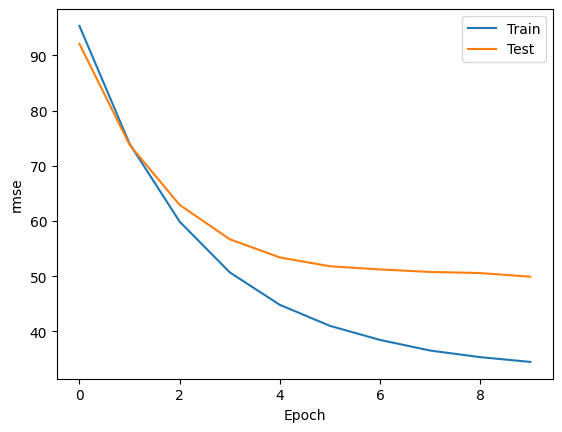

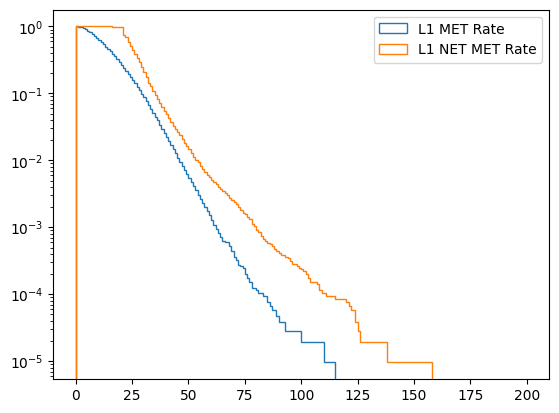

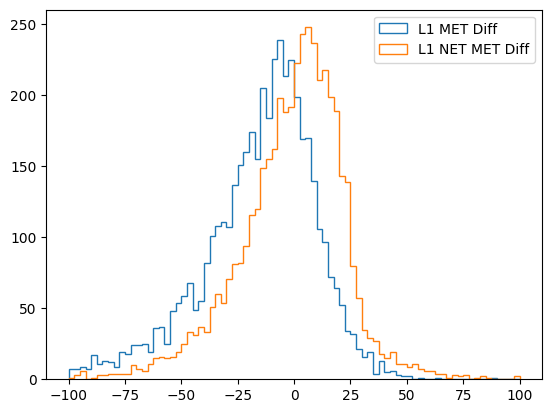

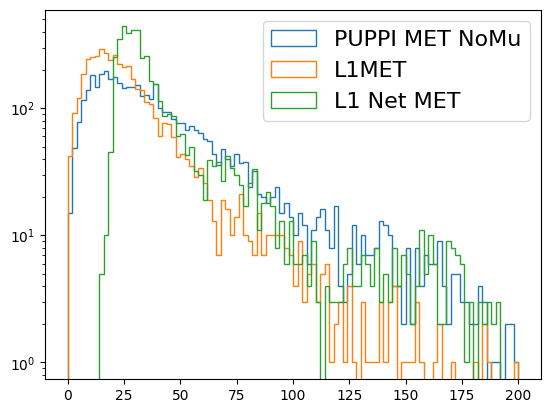

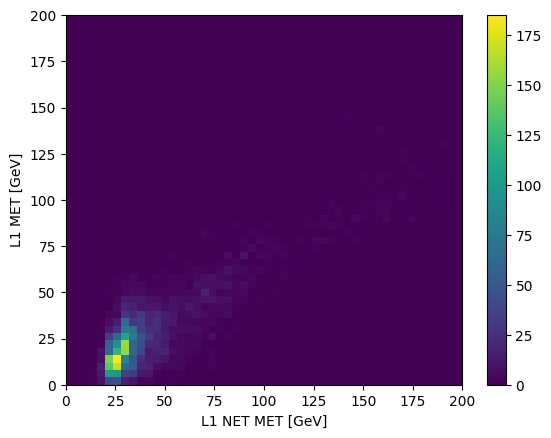

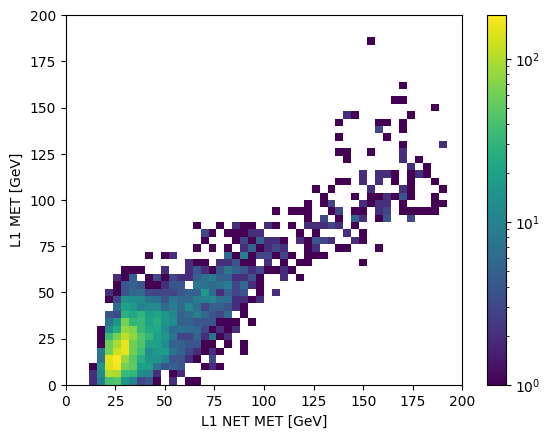

/tmp/jleonhol/ipykernel_1249466/1066460093.py:154: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(img[3])


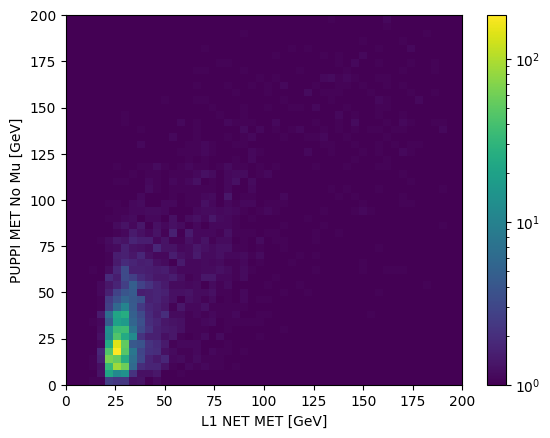

/tmp/jleonhol/ipykernel_1249466/1066460093.py:169: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(img[3])


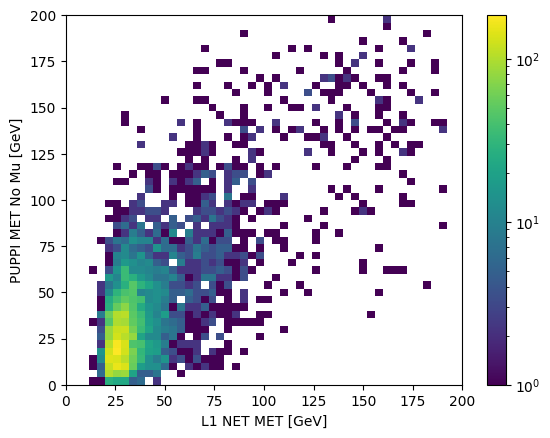

/eos/home-j/jleonhol/netmet/netmet/nanoaod_base_analysis/data/software/NetMET/lib64/python3.9/site-packages/awkward/_nplikes/array_module.py:285: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/eos/home-j/jleonhol/netmet/netmet/nanoaod_base_analysis/data/software/NetMET/lib64/python3.9/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/eos/home-j/jleonhol/netmet/netmet/nanoaod_base_analysis/data/software/NetMET/lib64/python3.9/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/eos/home-j/jleonhol/netmet/netmet/nanoaod_base_analysis/data/software/NetMET/lib64/python3.9/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initi

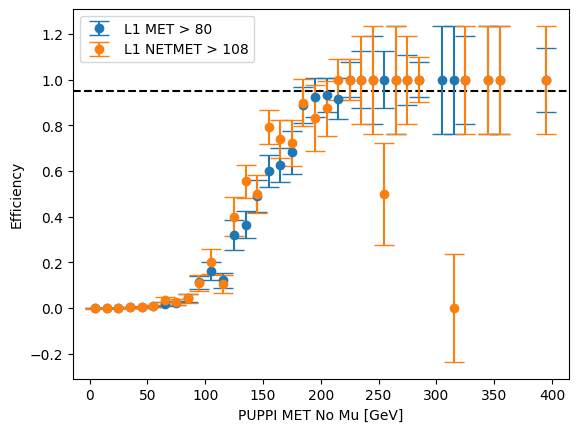

In [9]:
# Run training and validation

# dataset definition
p = Process("dummy", "Dummy process")
background_dataset = Dataset("background_nopum_new",
    folder="/eos/user/b/bundocka/jec/zb24I_noJEC_noPUS_noPUM/",
    process=p,
    check_empty=False,
)
signal_dataset = Dataset("signal_nopum_new",
    folder="/eos/user/b/bundocka/jec/zmu24I_noJEC_noPUS_noPUM/",
    process=p,
    check_empty=False,
)

run(signal_dataset, background_dataset)
